In [1]:
# from google.colab import drive
# import sys
# drive.mount('/content/drive',force_remount=True)
# sys.path.insert(0,'/content/drive/MyDrive/EPF notebooks/deep_learning_project')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from package import batch_gd, new_labels, report, convert_labels, compute_shapes, \
    train_dataset, test_dataset, transforms, train_loader, test_loader

# **Building a CNN**

In the simple_model notebook, we trained a simple CNN composed of 4 convolution layers and 3 dense layers. This model obtained 84% accuracy and 77% macro F1-score.

In this notebook, we'll build a more complex CNN using new layers and methods to avoid overfitting and improve on previous results.

### **Downloading data** 

In [3]:
len(train_dataset)

26640

# **Step 2: Modeling**

This time, we will add max pooling after the convolutions. Max pooling will select the maximal value out of a FxF kernel (most of the time this kernel is 2x2), this allows to downsample the feature maps and add some feature selection. 

Once again, we have to compute the shape of the feature maps at each layer of the model, this time we add two max pooling layers.

To make up for the downsampling of the pooling layers, the images are now reshaped to 120x120 pixels.

*   W = input shape
*   F = kernel size
*   P = padding
*   S = Stride
*   D = dilation (always 1 here)

Convolution: $W_{out} = \left \lfloor \frac{W - F + 2P}{S} \right \rfloor +1$

Max pooling: $W_{out} = \left \lfloor \frac{W +2*P - D * (F -1) -1}{S} +1 \right \rfloor$

In [4]:
print('AlexNet inspired model:')
compute_shapes(img_size=120, seq=['conv','max_pooling','conv','max_pooling','conv'])

AlexNet inspired model:
  0: conv => image size: 60.0
  1: max_pooling => image size: 30.0
  2: conv => image size: 15.0
  3: max_pooling => image size: 7.0
  4: conv => image size: 4.0


4.0

For this new architecture, I chose to create a smaller copy of the AlexNet architecture, combining convolutions and max pooling sequentially. 

In order to add some regularization, I also added batch normalization and dropout layers to the model. Batch Norm helps to reduce the covariate shift brought by the ReLU (this activation has non-zero mean) and the dropouts help to reduce the number of parameters in the model, making it more robust.

In [8]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        self.convolutions = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU(inplace=True),
        )

        self.Dense = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),

            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, K)
        )

    def forward(self, x):
        x = self.convolutions(x)
        flat = x.view(x.shape[0], -1)
        x = self.Dense(flat)
        return x

Now we instantiate the model and define the loss function and optimizer.
* The cross entropy loss is appropriate for a classification problem 
* Adam is a standard choice for an optimize

In [9]:
model = CNN(43)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

We use the same training loop as before :

In [10]:
train_losses, test_losses = batch_gd(model=model,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    train_loader=train_loader,
                                    test_loader=test_loader,
                                    early_stopping=False,
                                    early_stopper=None,
                                    epochs=10)

Epoch 1 / 10: Train Loss : 0.9033, Test Loss : 0.4427, duration: 0:00:31.289360
Epoch 2 / 10: Train Loss : 0.1445, Test Loss : 0.2990, duration: 0:00:29.272856
Epoch 3 / 10: Train Loss : 0.0839, Test Loss : 0.2606, duration: 0:00:29.791496
Epoch 4 / 10: Train Loss : 0.0590, Test Loss : 0.2209, duration: 0:00:29.354480
Epoch 5 / 10: Train Loss : 0.0570, Test Loss : 0.2611, duration: 0:00:30.310667
Epoch 6 / 10: Train Loss : 0.0317, Test Loss : 0.1980, duration: 0:00:29.481322
Epoch 7 / 10: Train Loss : 0.0316, Test Loss : 0.2561, duration: 0:00:29.442203
Epoch 8 / 10: Train Loss : 0.0363, Test Loss : 0.1983, duration: 0:00:29.446959
Epoch 9 / 10: Train Loss : 0.0298, Test Loss : 0.2574, duration: 0:00:29.465872
Epoch 10 / 10: Train Loss : 0.0270, Test Loss : 0.2111, duration: 0:00:29.316230


              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83        60
         1.0       0.91      0.98      0.94       720
         2.0       0.95      0.95      0.95       750
         3.0       0.87      0.94      0.91       450
         4.0       0.98      0.94      0.96       660
         5.0       0.87      0.90      0.89       630
         6.0       1.00      0.83      0.91       150
         7.0       0.92      0.90      0.91       450
         8.0       0.95      0.85      0.90       450
         9.0       0.97      0.96      0.97       480
        10.0       0.99      0.98      0.99       660
        11.0       0.84      0.98      0.91       420
        12.0       1.00      0.97      0.98       690
        13.0       0.98      1.00      0.99       720
        14.0       1.00      0.99      0.99       270
        15.0       1.00      0.99      0.99       210
        16.0       0.99      0.93      0.96       150
        17.0       0.97    

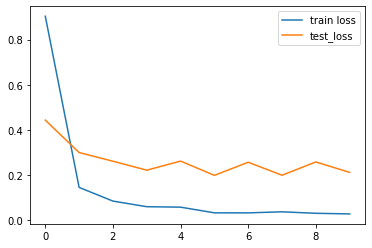

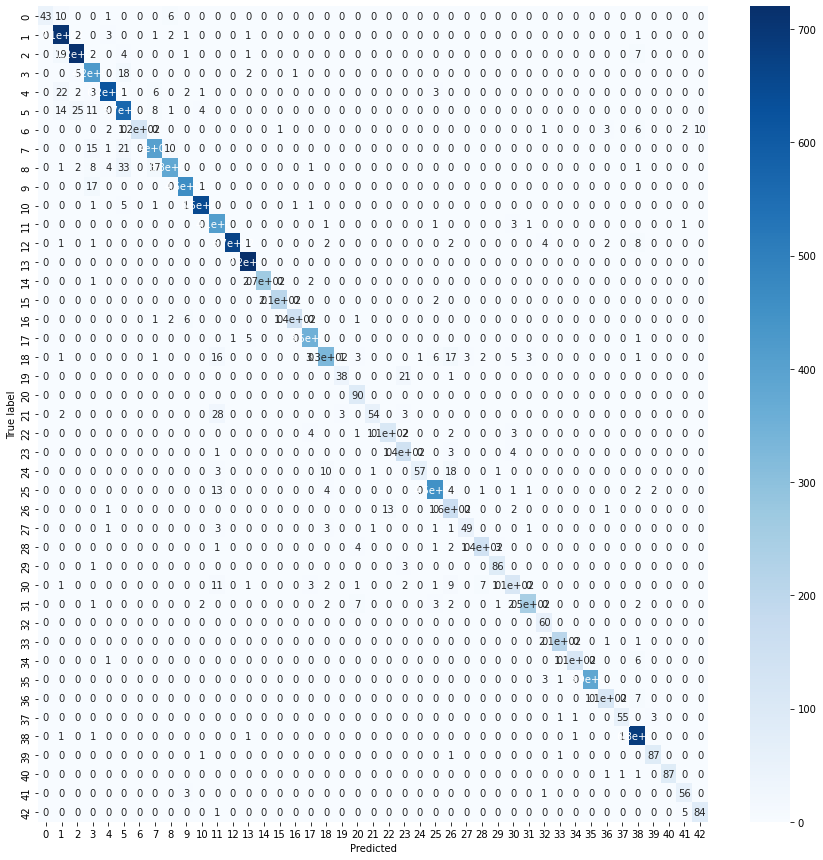

In [11]:
X_test, p_test, y_test = report(model,test_loader, train_losses, test_losses)

# **Conclusion**
This model obtain better performances with 94% accuracy and 92% macro F1-score.

Some classes have lower performances (from 75 to 83% in F1-score), this seems to be related to lower support. Solutions to this problem could be to augment the data (apply random rotations, cropping, color filters) or apply class weights during the training.

In [12]:
torch.save(model.state_dict(), '/content/drive/MyDrive/EPF notebooks/deep_learning_project/best_CNN')